# Interpolación de banda limitada para el tipo de cambio del dólar
Por [Juan M. Fonseca-Solís](https://juanfonsecasolis.github.io/), Mar 2015
- - - 
## Resumen

La reconstrucción de secuencias temporales continuas a partir de muestras tomadas de forma discreta es un problema que ha sido resuelto tradicionalmente usando el [teorema de Nyquist](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem), este teorema establece que la frecuencia de muestreo debe ser el doble de la frecuencia máxima contenida en la señal original para evitar la pérdida de información. La reconstrucción &ndash;también llamada interpolación&ndash; se logra [convolucionando](https://en.wikipedia.org/wiki/Convolution) una función de interpolación &ndash;también llamada núcleo de interpolación&ndash; con cada muestra disponible, luego se realiza una suma de todas las convoluciones para obtener la función continua; hasta aquí, teoría conocida. El problema se vuelve más complejo cuando se desea reconstruir la señal pero a partir de muestras tomadas aleatoriamente, es decir, sin una tasa de muestreo fija.<sup>1</sup> En este caso, si las frecuencias altas son despreciables, se puede usar el método de interpolación de banda limitada (BLI, por sus siglas en inglés) que utiliza las series de Fourier y el método de mínimos cuadrados para obtener una aproximación razonable. En este _ipython notebook_ se explica con mayor detalle en qué consiste el método mencionado y se presenta un ejemplo interpolando el tipo de cambio del dólar en Costa Rica ofrecido mensualmente por el Banco Central de Costa Rica (BCCR).

## Construcción de una señal discreta

Para registrar una señal continua del mundo real es inevitable hacer mediciones de forma discreta, así, por ejemplo, una persona con diabetes utiliza su glucómetro de cuatro a diez veces al día, pero no cada segundo, aunque sabe que el nivel de azúcar en la sangre puede variar a esa velocidad. Las anotaciones realizadas de la señal continua conforman lo que se conoce como señal discreta, y si esta señal es además finita, tiene las siguientes características:
* Contiene $N$ entradas 
* Su soporte temporal es $0<x_i \le T$ (expresado en segundo, minutos, horas, etc...)
* Puede representarse de forma compacta como $\{(x_i,z_i)\}_{i=0}^{N-1}$, donde $x_i$ es la variable independiente

## Interpolación
Por definir...

## Interpolación por banda limitada

Si la señal discreta es [lineal e invariante en el tiempo](https://en.wikipedia.org/wiki/Linear_time-invariant_system) puede modelarse como un sistema lineal, es decir, como la multiplicación entre una matriz de transformación y un vector de coeficientes, de la siguiente manera [2]:<sup>2</sup>

$$
Fc=z,\qquad (1)
$$

donde $\{F\}_{ik}=e^{j2\pi \frac{x_ik}{T}}$ es la $k$-ésima entrada del $i$-ésimo vector ortogonal de las series de Fourier y $c=(c_{-M}, \ldots, c_M)^t$ es el vector obtenido al aplicar la transformada de Fourier. Suponiendo que la cantidad de filas y columnas linealmente independientes de $F$ es el mismo (esto es, $N=2M+1$), es posible resolver el sistema encontrando la inversa de la matriz, de la siguiente manera:

$$
c=F^{-1}z.
$$

Sin embargo, en la vida real esto raramente vez ocurre porque la cantidad de muestras de la señal usualmente es mayor al número de coeficientes elegido para el modelado ($2M+1<N$). Afortunadamente, se puede mitigar este problema realizando una aproximación con el método de mínimos cuadrados [2]:<sup>3</sup>

$$
\hat{c}=(F^t F)^{-1}F^tz.
$$

Hasta aquí, esta aproximación no es una todavía una interpolación, porque modela la señal solo en los puntos que fueron muestreados, por lo que es necesario realizar un remuestreo lineal del soporte temporal $x_i$ en el intervalo $[0, T]$, y para ello se puede usar una simple regla de tres:

$$
\tilde{x}_i=i\frac{T}{L}.
$$

Finalmente, se sustituye $x_i$ por el $\tilde{x}_i$ en la ecuación 1, y el sistema resultante es modelado por Prandoni y Veterli en la siguiente expresión:

$$
\tilde{z}_i=\tilde{F}\hat{c}.
$$

## Consumo del servicio web del BCCR

Ahora vamos a la práctica con un ejemplo que consume el servicio web SOAP del BCCR disponible en el sitio `http://indicadoreseconomicos.bccr.fi.cr`. Empezamos importando los paquetes de la librería [Zolera Soap Infraestructure](http://pywebsvcs.sourceforge.net/zsi.html), entre otras utilidades. 

**Nota:** como prerequisito, es necesario instalar la librería Zolera usando la instrucción de Ubuntu: `sudo apt-get install python-zsi`.

In [2]:
import xml.etree.ElementTree as ET  # librería para leer el xml
from ZSI.ServiceProxy import ServiceProxy  # libería para consumir el servicio SOAP
import datetime
import numpy

La operación que permite obtener el tipo de cambio diario se llama "ObtenerIndicadoresEconomicosXML" y, según el _web service description language_ (WSDL) del BCCR, recibe cinco parámetros:
* **ID del indicador** (317, para el tipo de cambio de compra) [1]
* **Fecha inicial** (en formato dd/mm/yyy)
* **Fecha final** (igual que el anterior)
* **Nombre del usuario** (irrelevante, pues no afecta la operación)
* **Char Y/N** (comunica si se desea obtener un reporte detallado con subindicadores)

El resultado de la operación es un XML con la forma:

    <string><Datos_de_INGC011_CAT_INDICADORECONOMIC>
      <INGC011_CAT_INDICADORECONOMIC>
        <COD_INDICADORINTERNO>317</COD_INDICADORINTERNO>
        <DES_FECHA>2014-01-01T00:00:00-06:00</DES_FECHA>
        <NUM_VALOR>495.01000000</NUM_VALOR>
      </INGC011_CAT_INDICADORECONOMIC>
      (...)
    </Datos_de_INGC011_CAT_INDICADORECONOMIC></string>
    
El cual retorna un valor del tipo de cambio por día (fijando la frecuencia de muestreo en $f_s=1/86400$ s). Para consumir el servicio y obtener un arreglo de entradas tipo `float` a partir del XML usamos el siguiente código:<sup>4</sup>

In [3]:
# creamos un proxy con los servicios del WSDL
URL_WSDL = ("http://indicadoreseconomicos.bccr.fi.cr/\
IndicadoresEconomicos/WebServices/wsIndicadoresEconomicos.asmx?WSDL")
servicio = ServiceProxy(URL_WSDL)

# obtenemos la fecha de hoy según explica https://www.saltycrane.com/blog/2008/06/how-to-get-current-date-and-time-in/
now = datetime.datetime.now()
fechaInicio = '%s/%s/%s' % (now.day, now.month, now.year-1)
fechaFinal = '%s/%s/%s' % (now.day, now.month, now.year)

# encontramos el valor de compra del dólar durante todo el 2014
dicc = servicio.ObtenerIndicadoresEconomicosXML(
	tcIndicador='317',
	tcFechaInicio=fechaInicio,
	tcFechaFinal=fechaFinal,
	tcNombre = 'test',
	tnSubNiveles = 'N')

# sacamos el XML que viene encapsulado en el diccionario
xml = dicc['ObtenerIndicadoresEconomicosXMLResult']
raiz = ET.fromstring(xml)

# almacenamos los valores de cambio en un arreglo
zo = []
for hijo in raiz:
	act = float(hijo[2].text)
	zo.append(act)

Dado que el método hace la suposición de que no hay frecuencias altas en la señal a representar, y en nuestro caso, estas corresponden a información descartable pues representan tendencias transitorias, realizamos un filtrado pasabajas para obtener una versión suavizada.

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'Tipo cambio en colones')

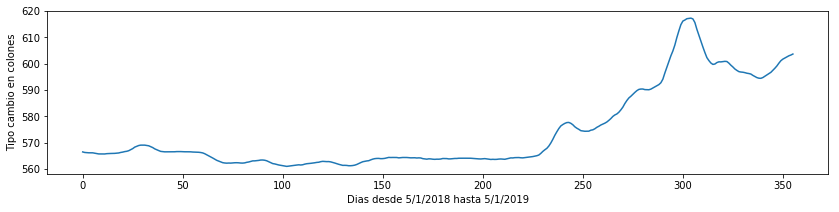

In [4]:
%pylab inline
%matplotlib inline

N = len(zo)
z = [0]*N
M=10
for n in range(M,N):
    z[n] = numpy.sum(zo[n-M:n])/M
z = z[M:N]
N = len(z)

# graficamos los valores obtenidos
x = numpy.arange(N)  # eje de las ordenadas
pylab.rcParams['figure.figsize'] = (14.0, 3.0) # dimensiones del gráfico
pylab.plot(x,z)
pylab.xlabel('Dias desde %s hasta %s' % (fechaInicio, fechaFinal))
pylab.ylabel('Tipo cambio en colones')

## Decimación aleatoria de la señal original

Para demostrar la utilidad de la BLI simulamos el caso en el que se toman muestras a intervalos aleatorios. Para ello, iteramos por las entradas de la señal original y conservamos cada muestra solo si el número aleatorio generado es menor a un valor $p$ definido.

Text(0,0.5,'Tipo de cambio en colones')

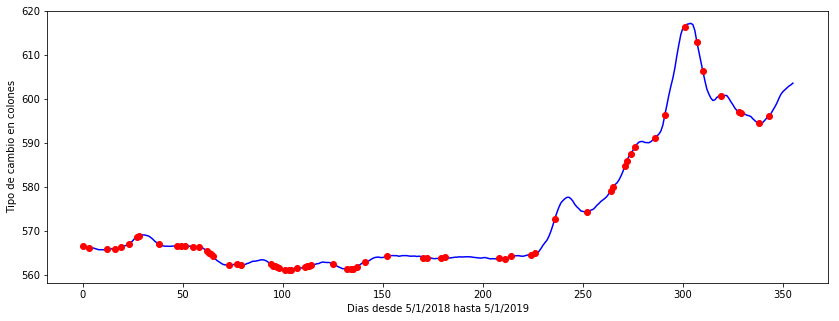

In [5]:
import random
p = 0.2 # probabilidad de conservar una muestra

xm = []
zm = []
for dia in range(len(x)):
    if random.random()<p:
        xm.append(x[dia])
        zm.append(z[dia])
    
# graficamos el resultado
pylab.rcParams['figure.figsize'] = (14.0, 5.0) # dimensiones del gráfico
pylab.plot(x,z,'b-',xm,zm,'or') 
pylab.xlabel('Dias desde %s hasta %s' % (fechaInicio, fechaFinal))
pylab.ylabel('Tipo de cambio en colones')

Aquí vemos puntos rojos que representan la nueva señal sobre la que vamos a trabajar. Una interpolación lineal uniría los puntos disponibles con una línea recta, pero la aproximación obtenida no sería suave (y por lo tanto su segunda derivada no existiría). Sin embargo procedemos a construirla para fines ilustrativos.

Text(0.5,1,'Mean squared error: 1.60')

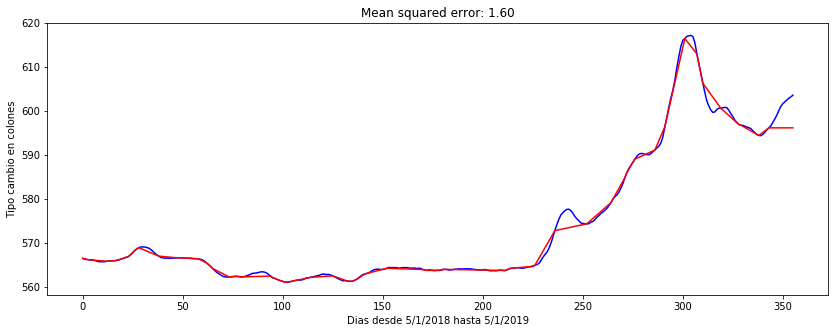

In [7]:
zm1 = numpy.interp(x, xm, zm, left=None, right=None, period=None)
pylab.plot(x,z,'b-',x,zm1,'r-')
pylab.xlabel('Dias desde %s hasta %s' % (fechaInicio, fechaFinal))
pylab.ylabel('Tipo cambio en colones')
error = numpy.mean(numpy.power(numpy.array(z)-numpy.array(zm1),2))
pylab.title('Mean squared error: %.2f' % error)

## Interpolación de banda limitada

Ahora usamos BLI para aproximar la señal original usando una curva más suave.

Text(0.5,1,'Mean squared error: 444.60')

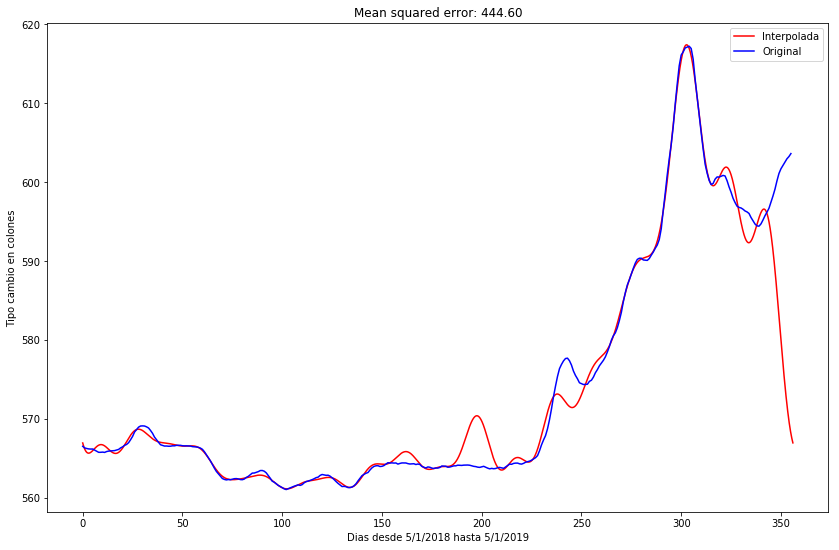

In [20]:
def BL_interp_1D(x, z, T, order, grid_step=0.01, win=True):
    """
    Band-limited interpolation of 1D functions (tomado de P.Prandoni y M.Vetterli)
    """
    # Create Fourier order vector
    k = np.expand_dims(arange(-order, order+1), 0)

    # construct the Fourier matrix
    F = exp(2j*pi*x*k/(T[1]-T[0]))

    # Least-square projection (alternatively linalg.lstsq can be used)
    C = dot(dot(linalg.inv(dot(F.T,F)), F.T), z)

    # create new evenly spaced grid
    xg = expand_dims(arange(T[0], T[1], grid_step), 1)

    # window the Fourier coefficients if requested
    if (win):
        C *= expand_dims(hanning(2*order+1), 1)

    zg = dot(exp(2j*pi*xg*k/(T[1]-T[0])), C)

    return zg, xg, C, k

'''
Aplicamos la interpolación BL
'''
orden = 20 # número de coeficientes de la aproximación (empírico)
T = [0, N]
xmp = expand_dims(array(xm),1)
zmp = expand_dims(array(zm),1)

# calculamos la interpolación BL
zp1, xp1, C1, k1 = BL_interp_1D(xmp, zmp, T, orden, win=False)

# graficamos el resultado
pylab.rcParams['figure.figsize'] = (14.0, 9.0) # dimensiones del gráfico
plot(xp1, numpy.real(zp1), 'r', x, z, 'b')
pylab.xlabel('Dias desde %s hasta %s' % (fechaInicio, fechaFinal))
pylab.ylabel('Tipo cambio en colones')
legend(('Interpolada', 'Original','Medidas'))
error = numpy.mean(numpy.power(numpy.array(z)-numpy.real(zp1),2))
pylab.title('Mean squared error: %.2f' % error)

Se obseva que la BLI presenta un MSE mayor en comparación con la interpolación lineal, pero la cantidad de picos estimados más precisa y la curva es derivable en todos los puntos, lo que la hace una mejor candidata para estudiar los puntos de inflexión. Si graficamos los coeficientes de Fourier obtenemos el siguiente gráfico:

(0, 10)

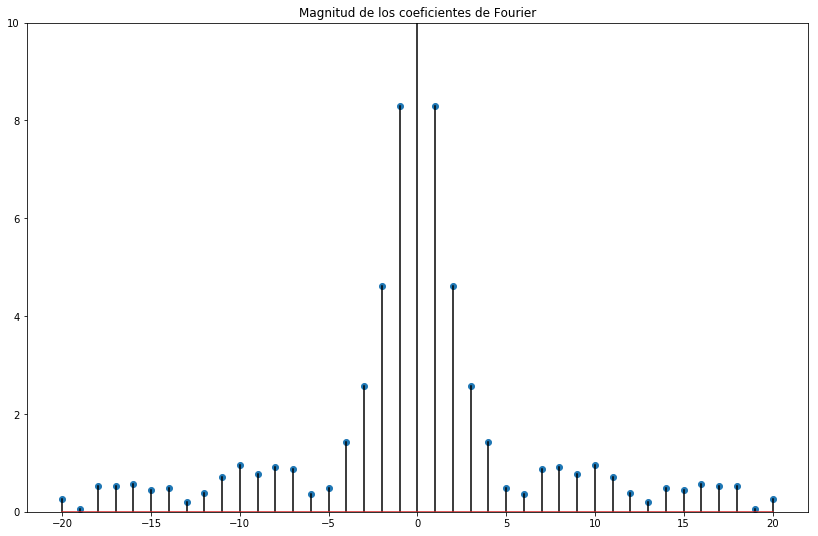

In [11]:
stem(k1.T, numpy.abs(C1), 'k')
title('Magnitud de los coeficientes de Fourier')
ylim([0,10])

## Cantidad de coeficientes

Como punto adicional, se pueden estudiar las series de Fourier como método de "compresión". Como la señal analizada en el ejemplo es real, los curva de coeficientes es simétrica (una propiedad de las series de Fourier), y por lo tanto no necesitamos almacenar los $2M+1$ coeficientes para realizar la reconstrucción. Recordando que $N$ es la cantidad de muestras de la señal original y $M$ la cantidad de coeficientes usados, esto nos permite calcular el "porcentaje de compresión" $c$ como sigue:

$$c=\frac{N-M}{N}.$$

In [17]:
c = float(N-orden)/N
print 'Muestras tomadas: %i' % N
print 'Cantidad de coeficientes: %i (necesarios para reproducir la señal)' % orden
print 'Compresión lograda: %i%%' % (c*100)

Muestras tomadas: 356
Cantidad de coeficientes: 20 (necesarios para reproducir la señal)
Compresión lograda: 94%


## Referencias:

1. Banco Central de Costa Rica. **Catálogo de indicadores económicos disponibles a consultar**. URL: http://www.bccr.fi.cr/indicadores_economicos_/ServicioWeb.html. Última vez consultado: 04/11/15

1. Ecolé Polytechnique Federale de Lausanne. **Band-limited interpolation of radiation measurements in Fukushima**.

## Notas
1. En estos casos se habla de una _tasa de innovación_ (FIR, por sus siglas en inglés), en lugar de frecuencia de muestreo.
2. Para escribir este ipython notebook se usó la sintaxis [Markdown](https://help.github.com/articles/markdown-basics/) y un interpretador [XML](https://docs.python.org/2/library/xml.etree.elementtree.html). Este documento también soporta $\LaTeX$.
3. Se recuerda que el método de mínimos cuadrados funciona usando el teorema de aproximación de la norma. Para saber más de este método visitar la [wikipedia](https://es.wikipedia.org/wiki/M%C3%ADnimos_cuadrados).
4. Un excelente recurso de cómo usar los servicios del BCCR también puede encontrarse en [Tico](https://tecnitico.wordpress.com/2010/11/11/webservice-del-banco-central-de-costa-rica-y-ruby/).

---
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="licencia Creative Commons" style="border-width:0" src="img/80x15.png" /></a><p style="text-align: center;"> Esta obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">licencia Creative Commons Atribución 4.0 Internacional</a>. El sitio juanfonsecasolis.github.io es un blog costarricence dedicado a la investigación independiente en temas relacionados al procesamiento digital de señales. Para reutilizar este artículo y citar la fuente puede usar Bibtex:</p>
```
@online{Fonseca2018,
  author = {Juan M. Fonseca-Solís},
  title = {Interpolación de banda limitada para el tipo de cambio del dólar},
  year = 2015,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.interpolacionBL.html},
  urldate = {}
}
```

<div id="disqus_thread"></div>
<script>

/**
*  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
*  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables
*/
var disqus_config = function () {
this.page.url = 'https://juanfonsecasolis.github.io/blog/JFonseca.interpolacionBL.html';  // Replace PAGE_URL with your page's canonical URL variable
this.page.identifier = 1; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
};

(function() { // DON'T EDIT BELOW THIS LINE
var d = document, s = d.createElement('script');
s.src = 'https://https-juanfonsecasolis-github-io.disqus.com/embed.js';
s.setAttribute('data-timestamp', +new Date());
(d.head || d.body).appendChild(s);
})();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript">comments powered by Disqus.</a></noscript>
<script id="dsq-count-scr" src="//https-juanfonsecasolis-github-io.disqus.com/count.js" async></script>